<a href="https://colab.research.google.com/github/Andrei198203/Data_Science_HW_8/blob/main/HW8_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)


    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Обчислюємо індекс максимального значення для кожного зразка
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Перетворюємо булеві значення на числа (True = 1, False = 0)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    params = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, params)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, params))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss}, accuracy: {acc}")

step: 100, loss: 585.7857055664062, accuracy: 0.140625
step: 200, loss: 584.5098266601562, accuracy: 0.15625
step: 300, loss: 582.4237670898438, accuracy: 0.1796875
step: 400, loss: 582.4258422851562, accuracy: 0.1640625
step: 500, loss: 581.2305908203125, accuracy: 0.2421875
step: 600, loss: 579.728271484375, accuracy: 0.2265625
step: 700, loss: 576.4706420898438, accuracy: 0.25390625
step: 800, loss: 578.68896484375, accuracy: 0.234375
step: 900, loss: 573.4388427734375, accuracy: 0.234375
step: 1000, loss: 577.5040283203125, accuracy: 0.19921875
step: 1100, loss: 567.6651000976562, accuracy: 0.265625
step: 1200, loss: 554.6475830078125, accuracy: 0.265625
step: 1300, loss: 541.45556640625, accuracy: 0.33203125
step: 1400, loss: 535.158935546875, accuracy: 0.30859375
step: 1500, loss: 527.8494873046875, accuracy: 0.29296875
step: 1600, loss: 517.0040283203125, accuracy: 0.31640625
step: 1700, loss: 501.8068542480469, accuracy: 0.34375
step: 1800, loss: 502.3047180175781, accuracy: 0.

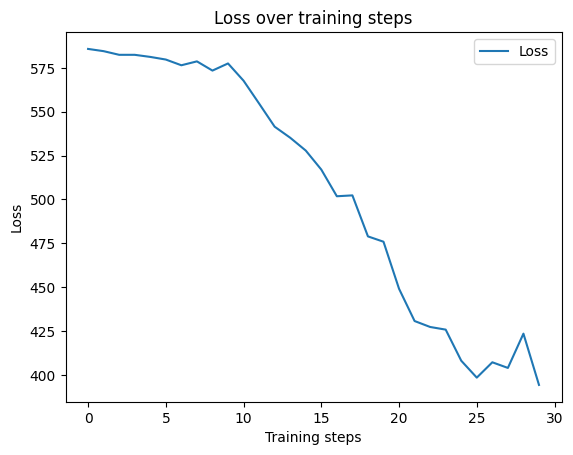

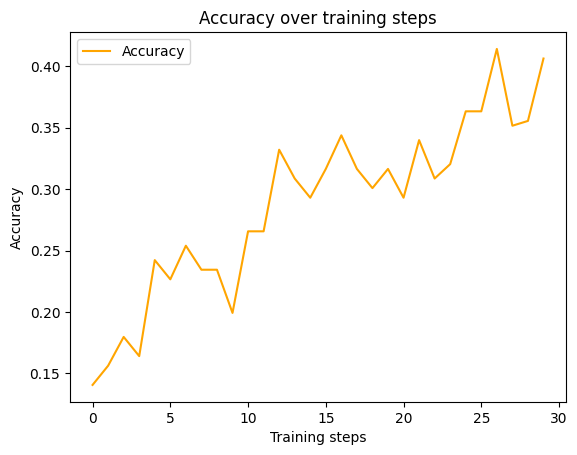

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.title('Loss over training steps')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Accuracy over training steps')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Обчисліть точність навченої нейромережі
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Test Accuracy: {test_accuracy}")
# Тестування моделі на тестових даних
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.40689998865127563
Test Accuracy: 0.40689998865127563


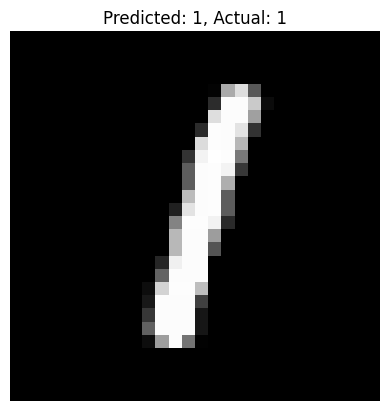

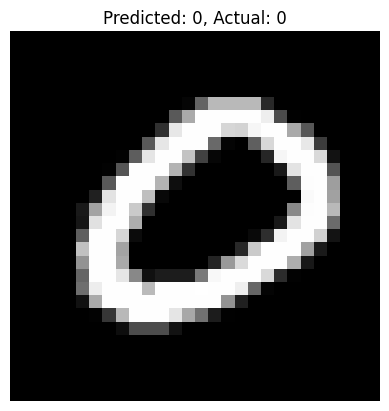

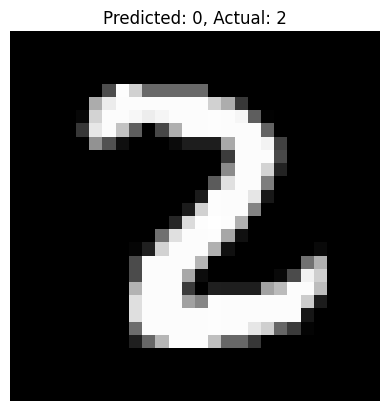

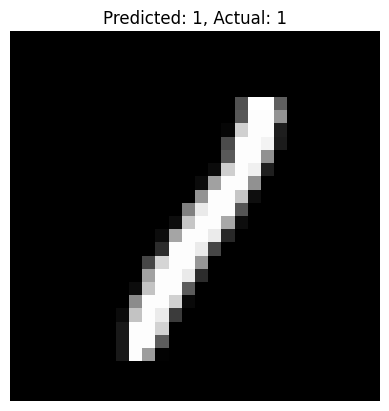

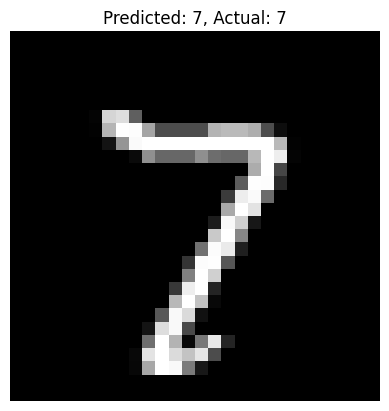

In [11]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виберемо 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), size=5, replace=False)
images = x_test[random_indices]
labels = y_test[random_indices]

# Передамо зображення у нейронну мережу та отримаємо передбачені мітки
predictions = neural_net(images)

# Виведемо зображення та передбачені мітки
for i in range(len(images)):
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0)}, Actual: {labels[i]}")
    plt.show()


За наданими результатами можемо зробити наступні висновки:

Для перших двох зображень модель правильно передбачила мітки (цифри 1 і 0).
Нейромережа помилилась на третьому зображенні, передбачивши цифру 0 замість 2.
Для наступних двох зображень модель також правильно передбачила мітки.
Отже, з цих п'яти прикладів модель зробила помилку лише в одному випадку. Це може свідчити про те, що нейронна мережа працює досить ефективно, але все ж може робити іноді помилки, особливо при класифікації складних зображень або зображень з поганим освітленням, пошкодженими чи нечіткими контурами.